# Covid-19 Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 08/Jul/2020 14:46

# Covid-19 model dynamics on SD

On this notebook, we'll explore and visualize multiple models of covid-19 behavior in a dynamic system approach. The models were written on cadCAD - a library for Complex Adaptive Dynamics simulations which allows you to mix and prototype 
different modelling paradigms in a reproducible and consistent manner.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x0000028FD2A7B208>, <cadCAD.configuration.Configuration object at 0x0000028FD2A84748>, <cadCAD.configuration.Configuration object at 0x0000028FD2A89F48>, <cadCAD.configuration.Configuration object at 0x0000028FD2A92C88>, <cadCAD.configuration.Configuration object at 0x0000028FD2A97F88>, <cadCAD.configuration.Configuration object at 0x0000028FD2AA7A08>, <cadCAD.configuration.Configuration object at 0x0000028FD2AA7A48>, <cadCAD.configuration.Configuration object at 0x0000028FD2AA7BC8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x0000028FD2A7B208>, <cadCAD.configuration.Configuration object at 0x0000028FD2A84748>, <cadCAD.configu

### Covid-19 SIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac{d}{dt}Infected}&=\beta * Infected * \frac {Susceptible}{Total Population} -\gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma *Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day [$\gamma$ = 1/recovery time in days]



# Covid-19 SIR model stock and flow diagram 
![covid-19 SIR model mechanism](images/covid-19_sir_model_stock_flow.png)

# Covid-19 SIR model mechanism 
![covid-19 SIR model mechanism](images/covid-19_sir_model.png)


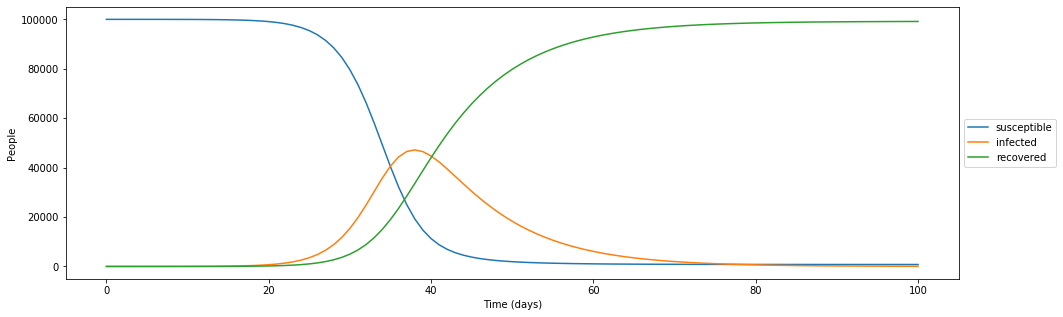

,susceptible,infected,recovered,run,substep,timestep
0,99999.000000,1.000000,0.000000,1,0,0
1,99998.500005,1.388884,0.111111,1,1,1
2,99997.805573,1.928995,0.265432,1,1,2
3,99996.841097,2.679139,0.479764,1,1,3
4,99995.501570,3.720983,0.777446,1,1,4
...,...,...,...,...,...,...
96,789.945321,104.147333,99105.907346,1,1,96
97,789.533968,92.986760,99117.479272,1,1,97
98,789.166887,83.021979,99127.811134,1,1,98
99,788.839296,74.124906,99137.035798,1,1,99


In [4]:
df = experiments.dataset[0] 
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(df['timestep'], df['susceptible'], label='susceptible'  )
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()
df

### Covid-19 SEIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - \gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma*Infected
\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1/D)
- $\delta$ expected rate that exposed people turn into infected



# Covid-19 SEIR model stock and flow diagram 
![covid-19 SEIR model mechanism](images/covid-19_seir_model_stock_flow.png)

# Covid-19 SEIR model mechanism 
![covid-19 SIR model mechanism](images/covid-19_seir_model.png)

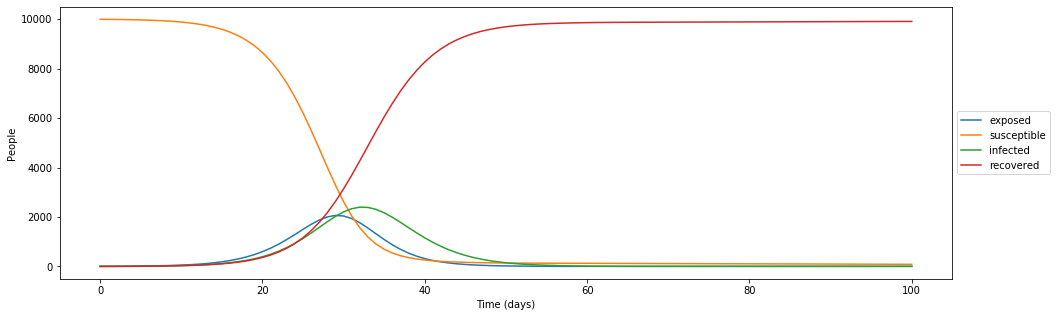

,susceptible,exposed,infected,recovered,run,substep,timestep
0,9990.0,10.0,0.0,0.0,1,0,0
1,9990.0,6.0,4.0,0.0,1,1,1
2,9986.0,8.0,5.0,1.0,1,1,2
3,9981.0,10.0,6.0,3.0,1,1,3
4,9975.0,12.0,8.0,5.0,1,1,4
...,...,...,...,...,...,...,...
96,90.0,3.0,4.0,9903.0,1,1,96
97,89.0,3.0,4.0,9904.0,1,1,97
98,88.0,3.0,4.0,9905.0,1,1,98
99,87.0,3.0,4.0,9906.0,1,1,99


In [5]:
df = experiments.dataset[1] 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()
df



### Covid-19 SEIRD model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha * \rho * Infected
\\{\frac {d}{dt}Recovered}&= (1 - \alpha) * \gamma *Infected
\\{\frac {d}{dt}Dead}&=\alpha * \rho * Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1 / D)
- $\delta$ expected rate that exposed people turn into infected
- $\rho$ rate at wich infected people die per day ($\rho$ = 1 / D)
- $\alpha$ death probability
- $R₀$: the total number of people an infected person infects (R₀ = β / γ)


# Covid-19 SEIRD model stock and flow diagram 
![covid-19 SEIRD model mechanism](images/covid-19_seird_model_stock_flow.png)

# Covid-19 SEIRD model mechanism 
![covid-19 SEIRD model mechanism](images/covid-19_seird_model.png)

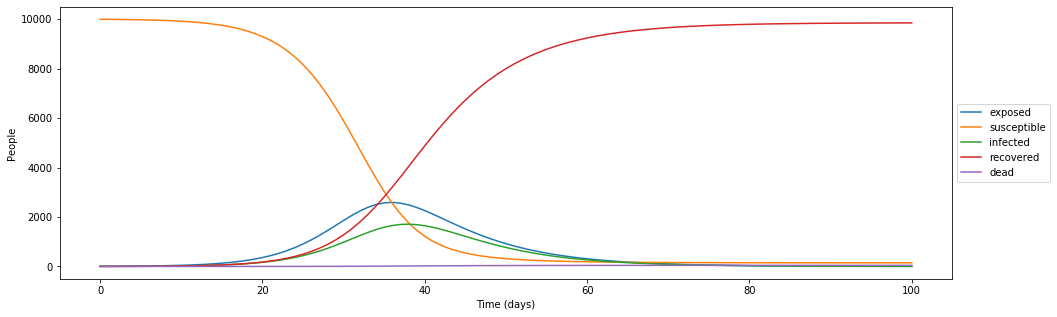

,susceptible,exposed,infected,recovered,dead,run,substep,timestep
0,9990.000000,10.000000,0.000000,0.000000,0.000000,1,0,0
1,9990.000000,6.666667,3.333333,0.000000,0.000000,1,1,1
2,9986.670000,8.603148,3.901852,0.825000,0.003704,1,1,2
3,9982.773349,10.602127,4.833816,1.790708,0.008039,1,1,3
4,9977.947861,13.095313,5.969748,2.987078,0.013410,1,1,4
...,...,...,...,...,...,...,...,...
96,146.973825,5.264452,4.515387,9843.246335,44.189658,1,1,96
97,146.907461,4.698575,4.030071,9844.363894,44.194675,1,1,97
98,146.848256,4.193508,3.596899,9845.361336,44.199153,1,1,98
99,146.795436,3.742721,3.210274,9846.251569,44.203150,1,1,99


In [6]:
df = experiments.dataset[2] 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
ax.plot(df['timestep'], df['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()
df

### Covid-19 SEIRD model with time variant R₀

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha * \rho * Infected
\\{\frac {d}{dt}Recovered}&= (1 - \alpha) * \gamma *Infected
\\{\frac {d}{dt}Dead}&=\alpha * \rho * Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1 / D)
- $\delta$ expected rate that exposed people turn into infected
- $\rho$ rate at wich infected people die per day ($\rho$ = 1 / D)
- $\alpha$ death probability
- $R₀$: the total number of people an infected person infects (R₀ = β / γ)


KeyError: 'exposed'

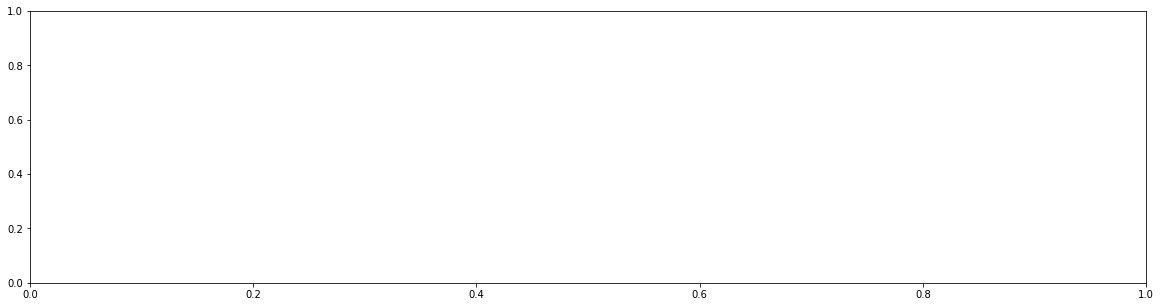

In [7]:
df = experiments.dataset[3] 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
ax.plot(df['timestep'], df['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### R₀ estimation from dataframe using SIR model

The idea is to read a dataframe with the information of susceptible, infected and recovered people and estimate R₀
\begin{aligned}\gamma(t) = {\frac {\frac {d}{dt}Recovered}{Infected}}
\\\beta(t) = {\frac {{\frac {d}{dt}Infected} + {\frac {d}{dt}Recovered}}{Infected * {\frac {Susceptible}{Total Population}}}}\end{aligned}


### Estimating R₀ from previous SIR model data

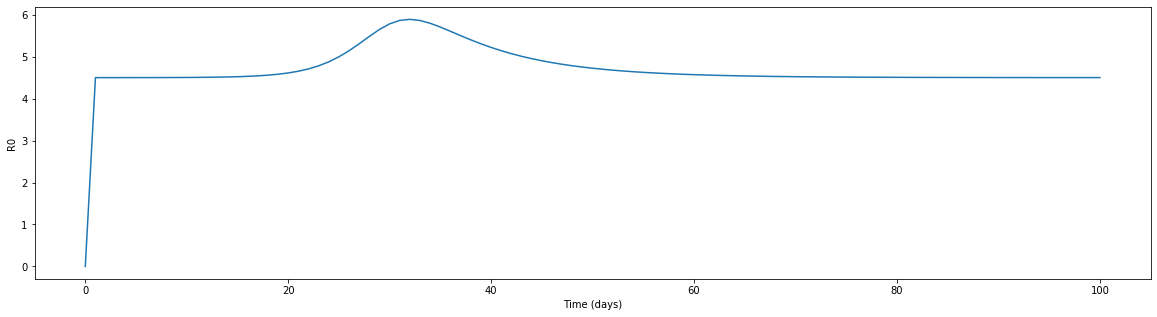

,r0,run,substep,timestep,r0_estimation
0,1,1,0,0,0.000000
1,1,1,1,1,4.500225
2,1,1,1,2,4.500313
3,1,1,1,3,4.500434
4,1,1,1,4,4.500603
...,...,...,...,...,...
96,1,1,1,96,4.501186
97,1,1,1,97,4.501059
98,1,1,1,98,4.500945
99,1,1,1,99,4.500844


In [8]:
r0_estimation = experiments.dataset[3]
r0_estimation = r0_estimation.fillna(0)
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(r0_estimation['timestep'], r0_estimation['r0_estimation'], label='r0_estimation')
ax.set_xlabel("Time (days)")
ax.set_ylabel("R0")
plt.show()
r0_estimation

### Estimating R₀ from external data source (São Paulo, SP)

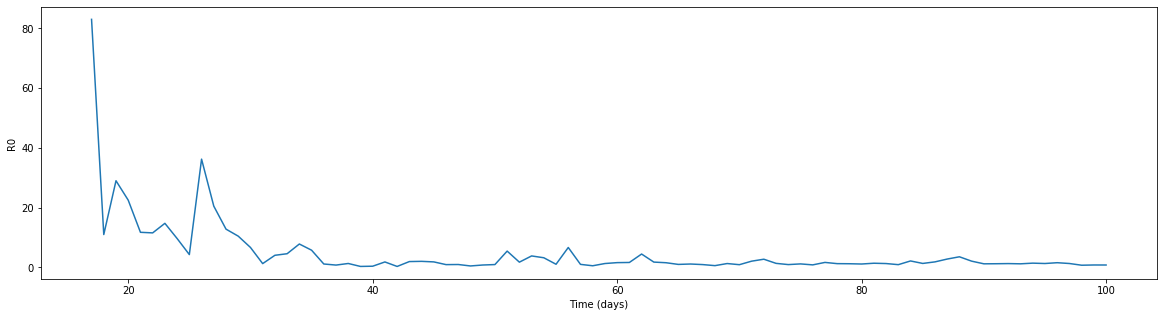

,r0,run,substep,timestep,r0_estimation
0,1,1,0,0,NaN
1,1,1,1,1,NaN
2,1,1,1,2,NaN
3,1,1,1,3,inf
4,1,1,1,4,NaN
5,1,1,1,5,NaN
6,1,1,1,6,NaN
7,1,1,1,7,NaN
8,1,1,1,8,inf
9,1,1,1,9,inf


In [22]:
r0_estimation = experiments.dataset[4]
#r0_estimation = r0_estimation[90:]
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(r0_estimation['timestep'], r0_estimation['r0_estimation'], label='r0_estimation')
ax.set_xlabel("Time (days)")
ax.set_ylabel("R0")
plt.show()
r0_estimation

In [10]:
import requests
import json
import pandas as pd
pd.set_option('display.max_rows', None)
req = requests.get('https://brasil.io/api/dataset/covid19/caso/data?state=SP&city=São Paulo')
data = json.loads(req.text)
df = pd.DataFrame.from_dict(data['results'])
df.to_csv('sp_data_filter.csv')
df = df.iloc[::-1]
r0_estimation = df.filter(items=['estimated_population_19', 'confirmed', 'deaths', 'date'],axis=1)
r0_estimation.reset_index(drop=True, inplace=True)
r0_estimation
df

,city,city_ibge_code,confirmed,confirmed_per_100k_inhabitants,date,death_rate,deaths,estimated_population_2019,is_last,order_for_place,place_type,state
124,São Paulo,3550308,1,0.00816,2020-02-25,0.0000,0,12252023,False,1,city,SP
123,São Paulo,3550308,1,0.00816,2020-02-26,0.0000,0,12252023,False,2,city,SP
122,São Paulo,3550308,1,0.00816,2020-02-27,0.0000,0,12252023,False,3,city,SP
121,São Paulo,3550308,2,0.01632,2020-02-28,0.0000,0,12252023,False,4,city,SP
120,São Paulo,3550308,2,0.01632,2020-02-29,0.0000,0,12252023,False,5,city,SP
119,São Paulo,3550308,2,0.01632,2020-03-01,0.0000,0,12252023,False,6,city,SP
118,São Paulo,3550308,2,0.01632,2020-03-02,0.0000,0,12252023,False,7,city,SP
117,São Paulo,3550308,2,0.01632,2020-03-03,0.0000,0,12252023,False,8,city,SP
116,São Paulo,3550308,3,0.02449,2020-03-04,0.0000,0,12252023,False,9,city,SP
115,São Paulo,3550308,6,0.04897,2020-03-05,0.0000,0,12252023,False,10,city,SP


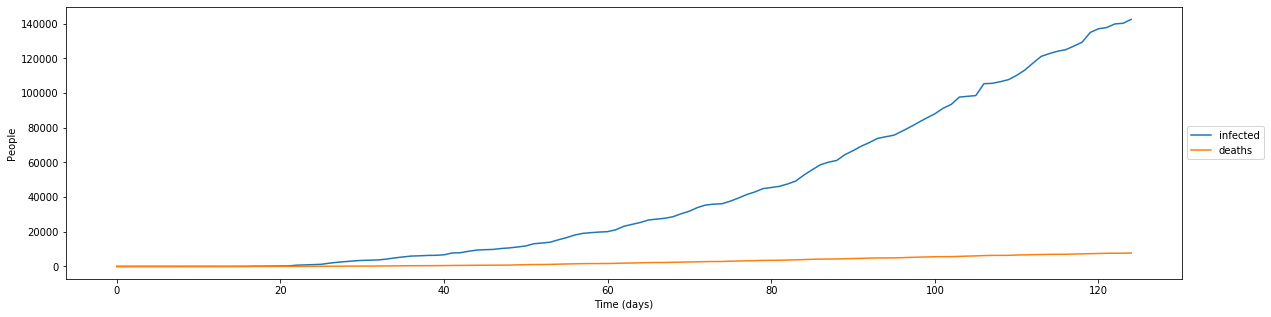

In [11]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(r0_estimation['confirmed'], label='infected')
ax.plot(r0_estimation['deaths'], label='deaths')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

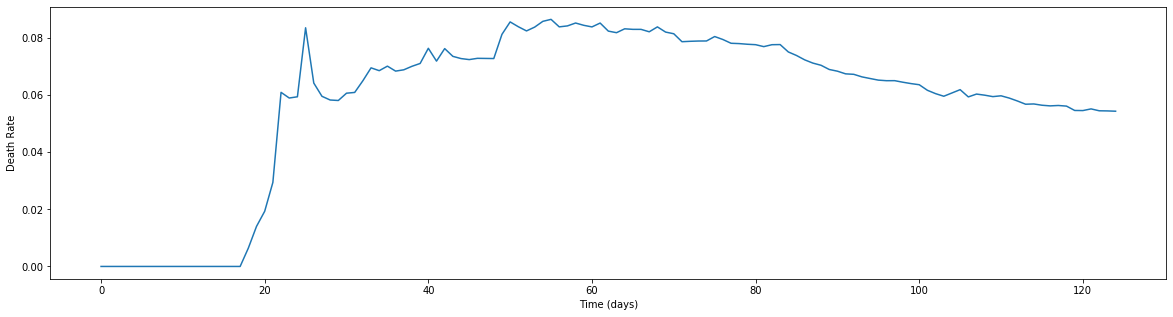

In [14]:
fig, ax = plt.subplots()
ax.plot(r0_estimation['deaths']/r0_estimation['confirmed'])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Death Rate")
plt.show()

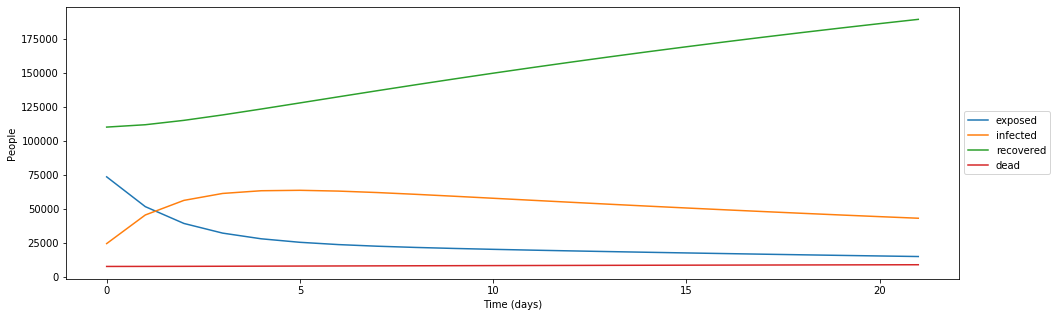

In [15]:
# R0 = 0.5
seird_predict_low = experiments.dataset[5]

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['exposed'], label='exposed')
#ax.plot(seird_predict_low['timestep'], seird_predict_low['susceptible'], label='susceptible')
ax.plot(seird_predict_low['timestep'], seird_predict_low['infected'], label='infected'   )
ax.plot(seird_predict_low['timestep'], seird_predict_low['recovered'], label='recovered')
ax.plot(seird_predict_low['timestep'], seird_predict_low['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

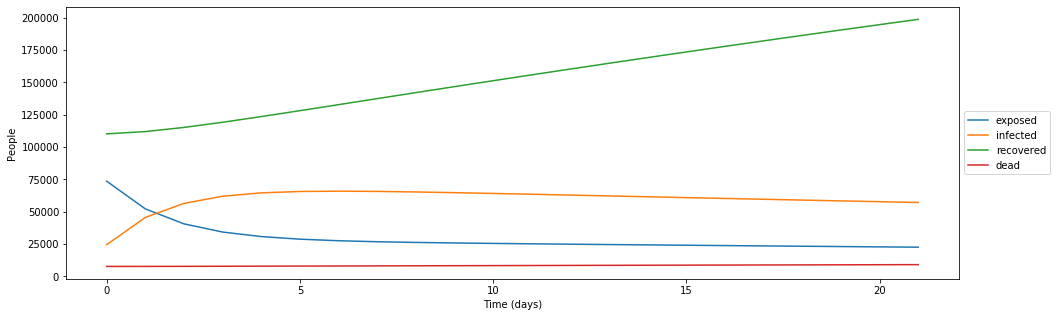

In [16]:
# R0 = 0.8
seird_predict = experiments.dataset[6] 

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict['timestep'], seird_predict['exposed'], label='exposed')
#x.plot(seird_predict_low['timestep'], seird_predict_low['susceptible'], label='susceptible')
ax.plot(seird_predict['timestep'], seird_predict['infected'], label='infected'   )
ax.plot(seird_predict['timestep'], seird_predict['recovered'], label='recovered')
ax.plot(seird_predict['timestep'], seird_predict['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

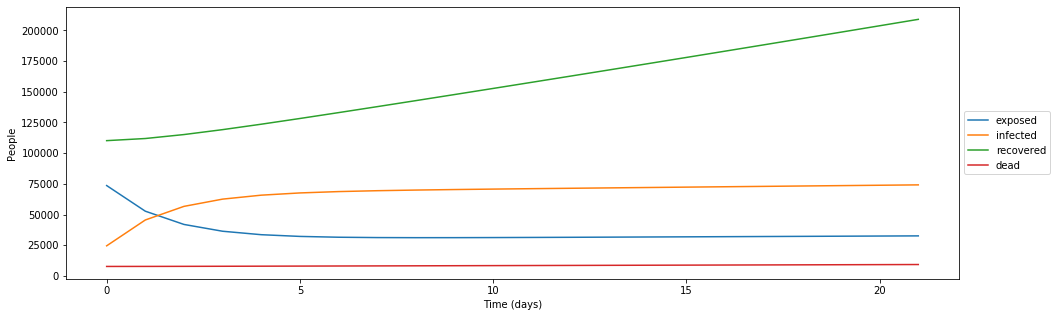

In [17]:
# R0 = 1.1
seird_predict_high = experiments.dataset[7] 

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict_high['timestep'], seird_predict_high['exposed'], label='exposed')
#x.plot(seird_predict_high['timestep'], seird_predict_high['susceptible'], label='susceptible')
ax.plot(seird_predict_high['timestep'], seird_predict_high['infected'], label='infected'   )
ax.plot(seird_predict_high['timestep'], seird_predict_high['recovered'], label='recovered')
ax.plot(seird_predict_high['timestep'], seird_predict_high['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

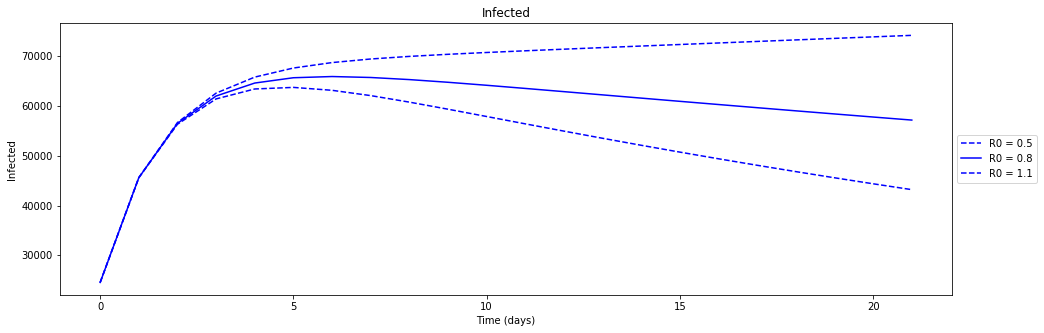

In [18]:
# Infected

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['infected'], 'b--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['infected'], 'b', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['infected'], 'b--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("Infected")
plt.title("Infected")
plt.show()

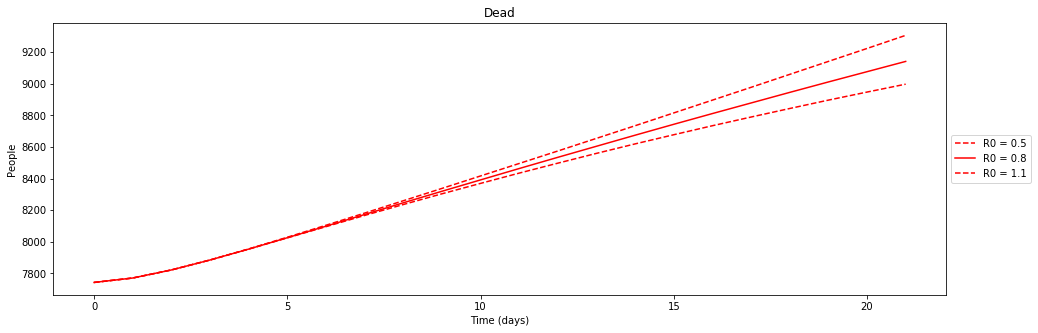

In [19]:
# Dead

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['dead'],'r--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['dead'], 'r', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['dead'], 'r--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.title("Dead")
plt.show()

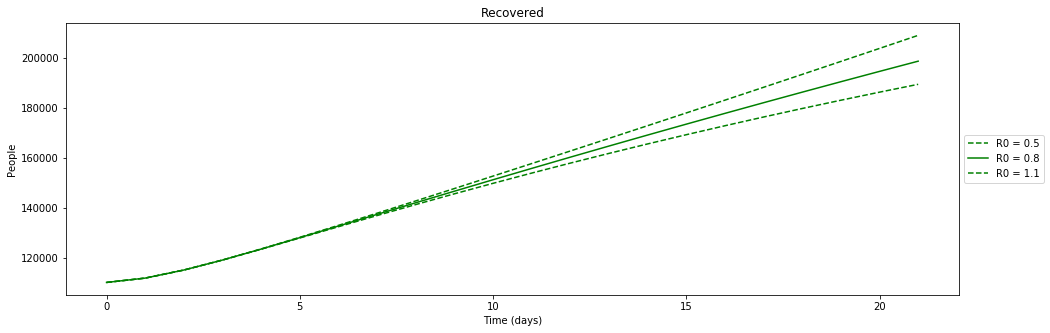

In [20]:
# Recovered

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['recovered'], 'g--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['recovered'], 'g', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['recovered'], 'g--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.title("Recovered")
plt.show()

### Conclusions and final words

### Proposed challenges

#### Make R₀ time dependent


#### Variable death rate



#### Stochasticity of the parameters



#### Add real data

